# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from stork.datasets import make_coRandman, RasDataset, split_dataset
from stork.activations import SuperSpike
from stork.regularizers import LowerBoundL2, UpperBoundL2
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DeltaSynapseLIFGroup
from stork.connections import Connection, SuperConnection
from stork.generators import StandardGenerator
from stork.initializers import     KaimingNormalInitializer
from stork.monitors import SpikeCountMonitor, StateMonitor
from stork.optimizers import SMORMS3
from stork.loss_stacks import MaxOverTimeCrossEntropy
from stork.plotting import plot_activity_snapshot

## Generate Dataset

Specify the Dataset Parameters

In [2]:
dim_manifold = 1
nb_sub_classes = 3
nb_classes = nb_sub_classes**2
nb_inputs = 10

nb_time_steps = 150
T_delay = 30
sample_duration = 30


nb_samples = 30
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt

## Create delay task

In [3]:
data, labels = make_coRandman(
    dim_manifold=dim_manifold,
    nb_classes=nb_sub_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=sample_duration / nb_time_steps,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
    T_delay=T_delay + sample_duration,
)

In [4]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(
        data, labels, splits=[0.8, 0.1, 0.1], shuffle=False
    )
]
ds_train, ds_valid, ds_test = datasets

In [5]:
print(len(ds_train))

6480


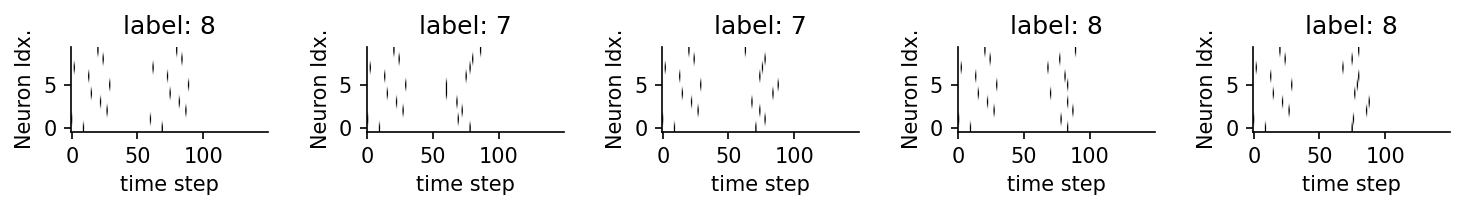

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [7]:
# Model Parameters
batch_size = 250
beta = 20
device = torch.device("cuda:0")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

tau_filter = 10e-3
nb_filters = 10

lr = 5e-3
nb_epochs = 10

In [8]:
act_fn = SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [9]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    DeltaSynapseLIFGroup(
        nb_hidden_units,
        tau_mem=tau_mem,
        # tau_syn=tau_syn,
        activation=act_fn,
    )
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [10]:
con = model.add_connection(
    SuperConnection(
        input_group, hidden_neurons, tau_filter=tau_filter, nb_filters=nb_filters
    )
)
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [11]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Define regularizer list
regs = []

regLB = LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [12]:
sigma_u = 1.0
nu = nb_spikes / duration

initializer = KaimingNormalInitializer(gain=15.0)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [13]:
model.add_monitor(SpikeCountMonitor(model.groups[1]))
model.add_monitor(StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [14]:
loss_stack = MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [15]:
opt = SMORMS3
generator = StandardGenerator(nb_workers=2)

In [16]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

Before we train the model, we monitor the spikes

In [17]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq_init"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [13.855613425925926]}


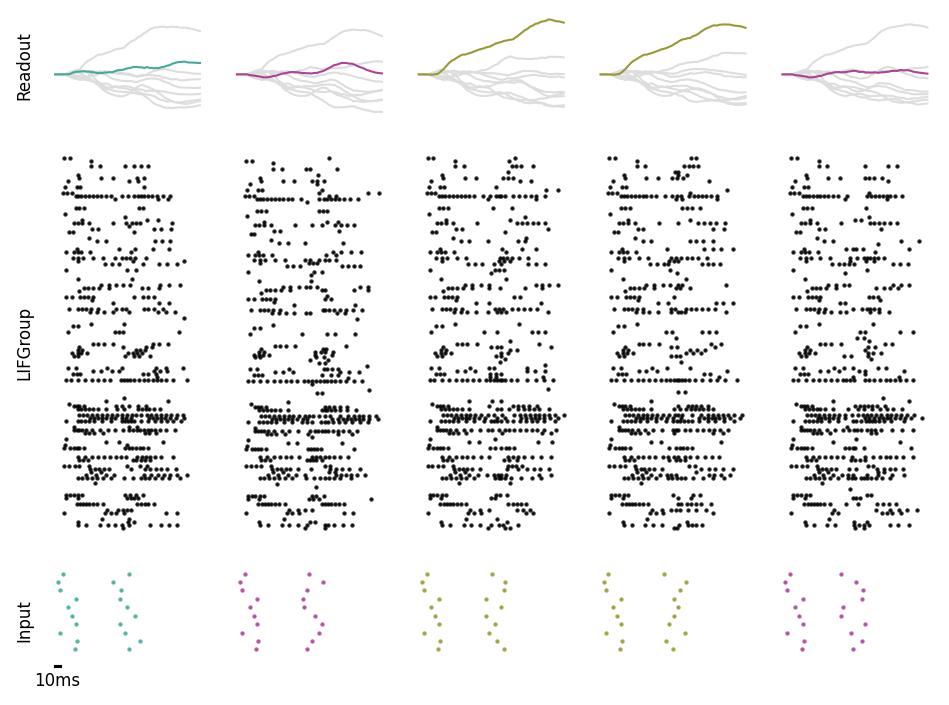

In [18]:
plt.figure(dpi=150)
plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False
)

## Training


In [19]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=2.4 reg_loss=0.00112 acc=0.144 -- val_loss=2.23 val_reg_loss=0.000464 val_acc=0.142 t_iter=5.84
01  loss=2.12 reg_loss=0.000545 acc=0.237 -- val_loss=2.25 val_reg_loss=0.000899 val_acc=0.111 t_iter=4.99
02  loss=2.04 reg_loss=0.000755 acc=0.299 -- val_loss=2.27 val_reg_loss=0.000767 val_acc=0.1 t_iter=5.01
03  loss=1.98 reg_loss=0.00072 acc=0.326 -- val_loss=2.21 val_reg_loss=0.000797 val_acc=0.187 t_iter=4.99
04  loss=1.91 reg_loss=0.00101 acc=0.361 -- val_loss=2.16 val_reg_loss=0.00119 val_acc=0.207 t_iter=4.83
05  loss=1.86 reg_loss=0.00123 acc=0.395 -- val_loss=2.2 val_reg_loss=0.00128 val_acc=0.181 t_iter=4.80
06  loss=1.8 reg_loss=0.00112 acc=0.412 -- val_loss=2.14 val_reg_loss=0.00138 val_acc=0.218 t_iter=4.77
07  loss=1.73 reg_loss=0.00118 acc=0.443 -- val_loss=2.14 val_reg_loss=0.00144 val_acc=0.181 t_iter=4.57
08  loss=1.66 reg_loss=0.00104 acc=0.461 -- val_loss=2.08 val_reg_loss=0.00115 val_acc=0.241 t_iter=4.74
09  loss=1.56 reg_loss=0.00111 acc=0.5 -- val_loss=2.0

#### Monitor the model again after training

In [20]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
results["avg_layer_freq"] = [
    nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

## Test

In [21]:
scores = model.evaluate(ds_test).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  1.6401816010475159
Test acc.:  47.98 %


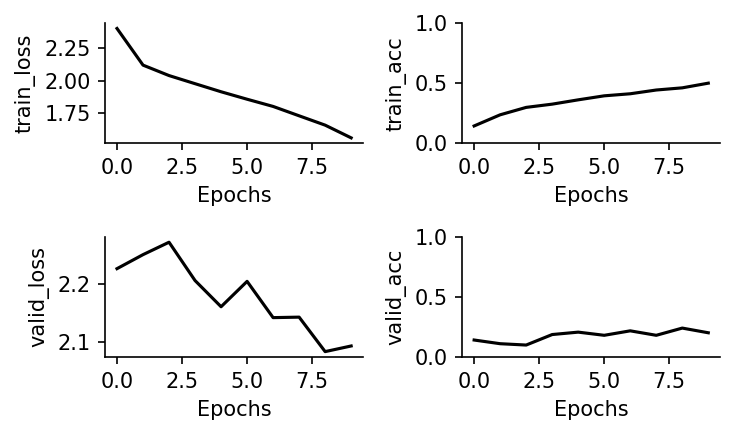

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"] * 100, 2), "%")

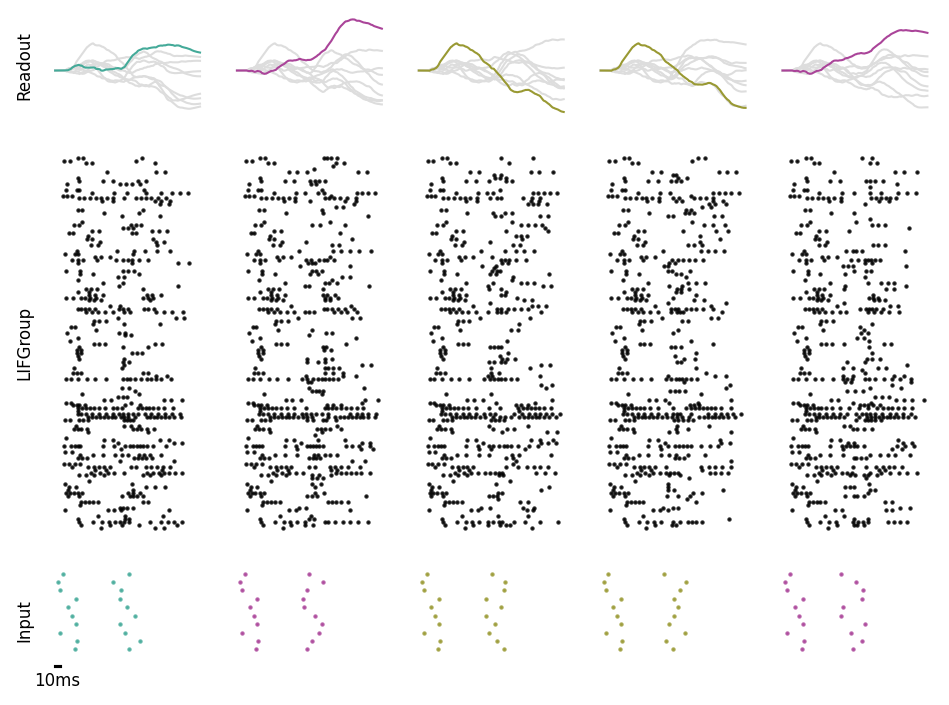

In [24]:
plt.figure(dpi=150)
plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False, nb_samples=5
)